In [1]:
import os
# When using on Juypter Notebook, uncomment the code below
# import sys
# path = os.path.join(os.path.dirname(os.getcwd()))
# sys.path.append(path) 
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output as clear
from models.inter_initial_model import CNNBiGRU
from trainTest.datasets.common_dataset_utils import get_file_name
from trainTest.datasets.intra_dl_dataset_utils import get_dl_datasets, get_dl_dataloaders
from trainTest.datasets.inter_dl_dataset_utils import get_source_datasets
from trainTest.inter_train_test.train_test_dl_models_source import train_test_dl_models_source
from trainTest.inter_train_test.train_test_dl_models_target import train_test_dl_models_target
from utils.common_utils import calculate_and_save_metrics, printlog
from utils.common_params import *

In [2]:
# 1. Parameter settings
subjects_list_global = list(['01', '02', '03', '04', '05', '31', '32', '33', '34', '35'])
total_exp_time = K_of_repeated_experiments if partitioning_method == 'repeated_experiments' else K_of_cross_validation 
settings = {'total_exp_time': total_exp_time}
# 2. Comparison of different denoising methods and transfer learning techniques
emg_denoise_methods = ['rawdata', 'EMD-PE-GT', 'ICEEMDAN-PE-SVD']
tl_types = ['OnlyTest', 'FineTuning-Linear', 'FineTuning-All', 'LoRA-Linear', 'LoRA-All', 'DoRA-Linear', 'DoRA-All']

### 1. Source Domain Model Training and Test

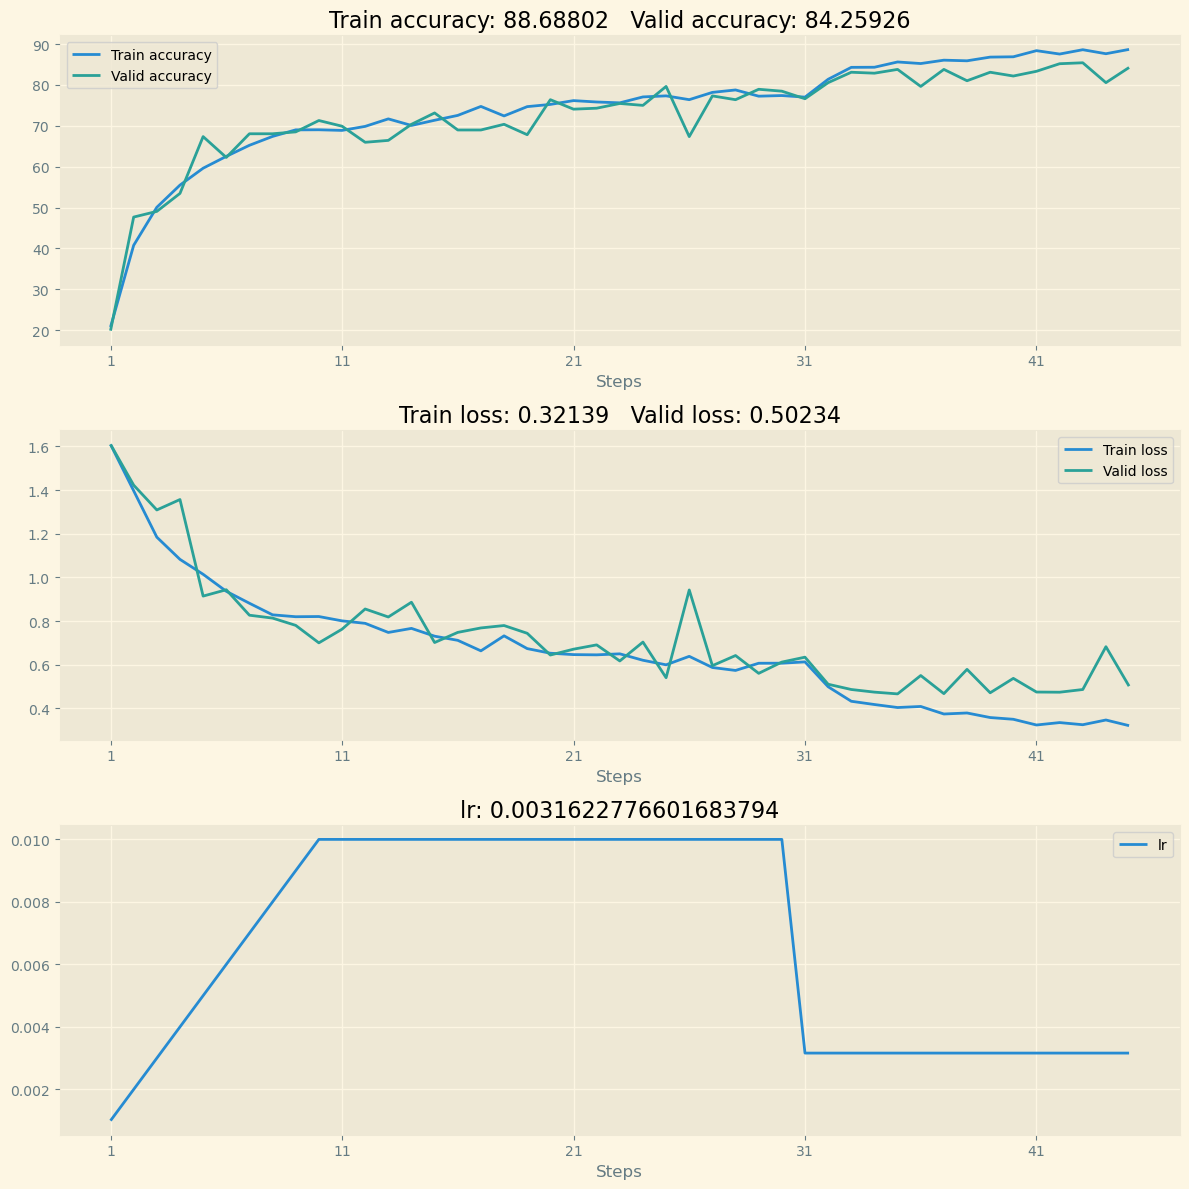

EarlyStopping counter: 10 out of 10
Early stopping, save the model: 
Save the model training process: 
Test results: 
accuracy:  81.46432.
precision:  80.85408.
recall:  81.12618.
f1:  80.84153.
specificity:  95.28495.
npv:  95.25646.
Calculate confusion matrix: 
Confusion Matrix: 
[[191   1   3  11  11]
 [  1  98  12   6   1]
 [ 10  13 113   4  16]
 [ 27   8   2 253  17]
 [ 25   2  15  15 224]]
Normalized Confusion Matrix: 
[[88.01843318  0.46082949  1.38248848  5.06912442  5.06912442]
 [ 0.84745763 83.05084746 10.16949153  5.08474576  0.84745763]
 [ 6.41025641  8.33333333 72.43589744  2.56410256 10.25641026]
 [ 8.79478827  2.60586319  0.6514658  82.41042345  5.53745928]
 [ 8.89679715  0.71174377  5.33807829  5.33807829 79.71530249]]


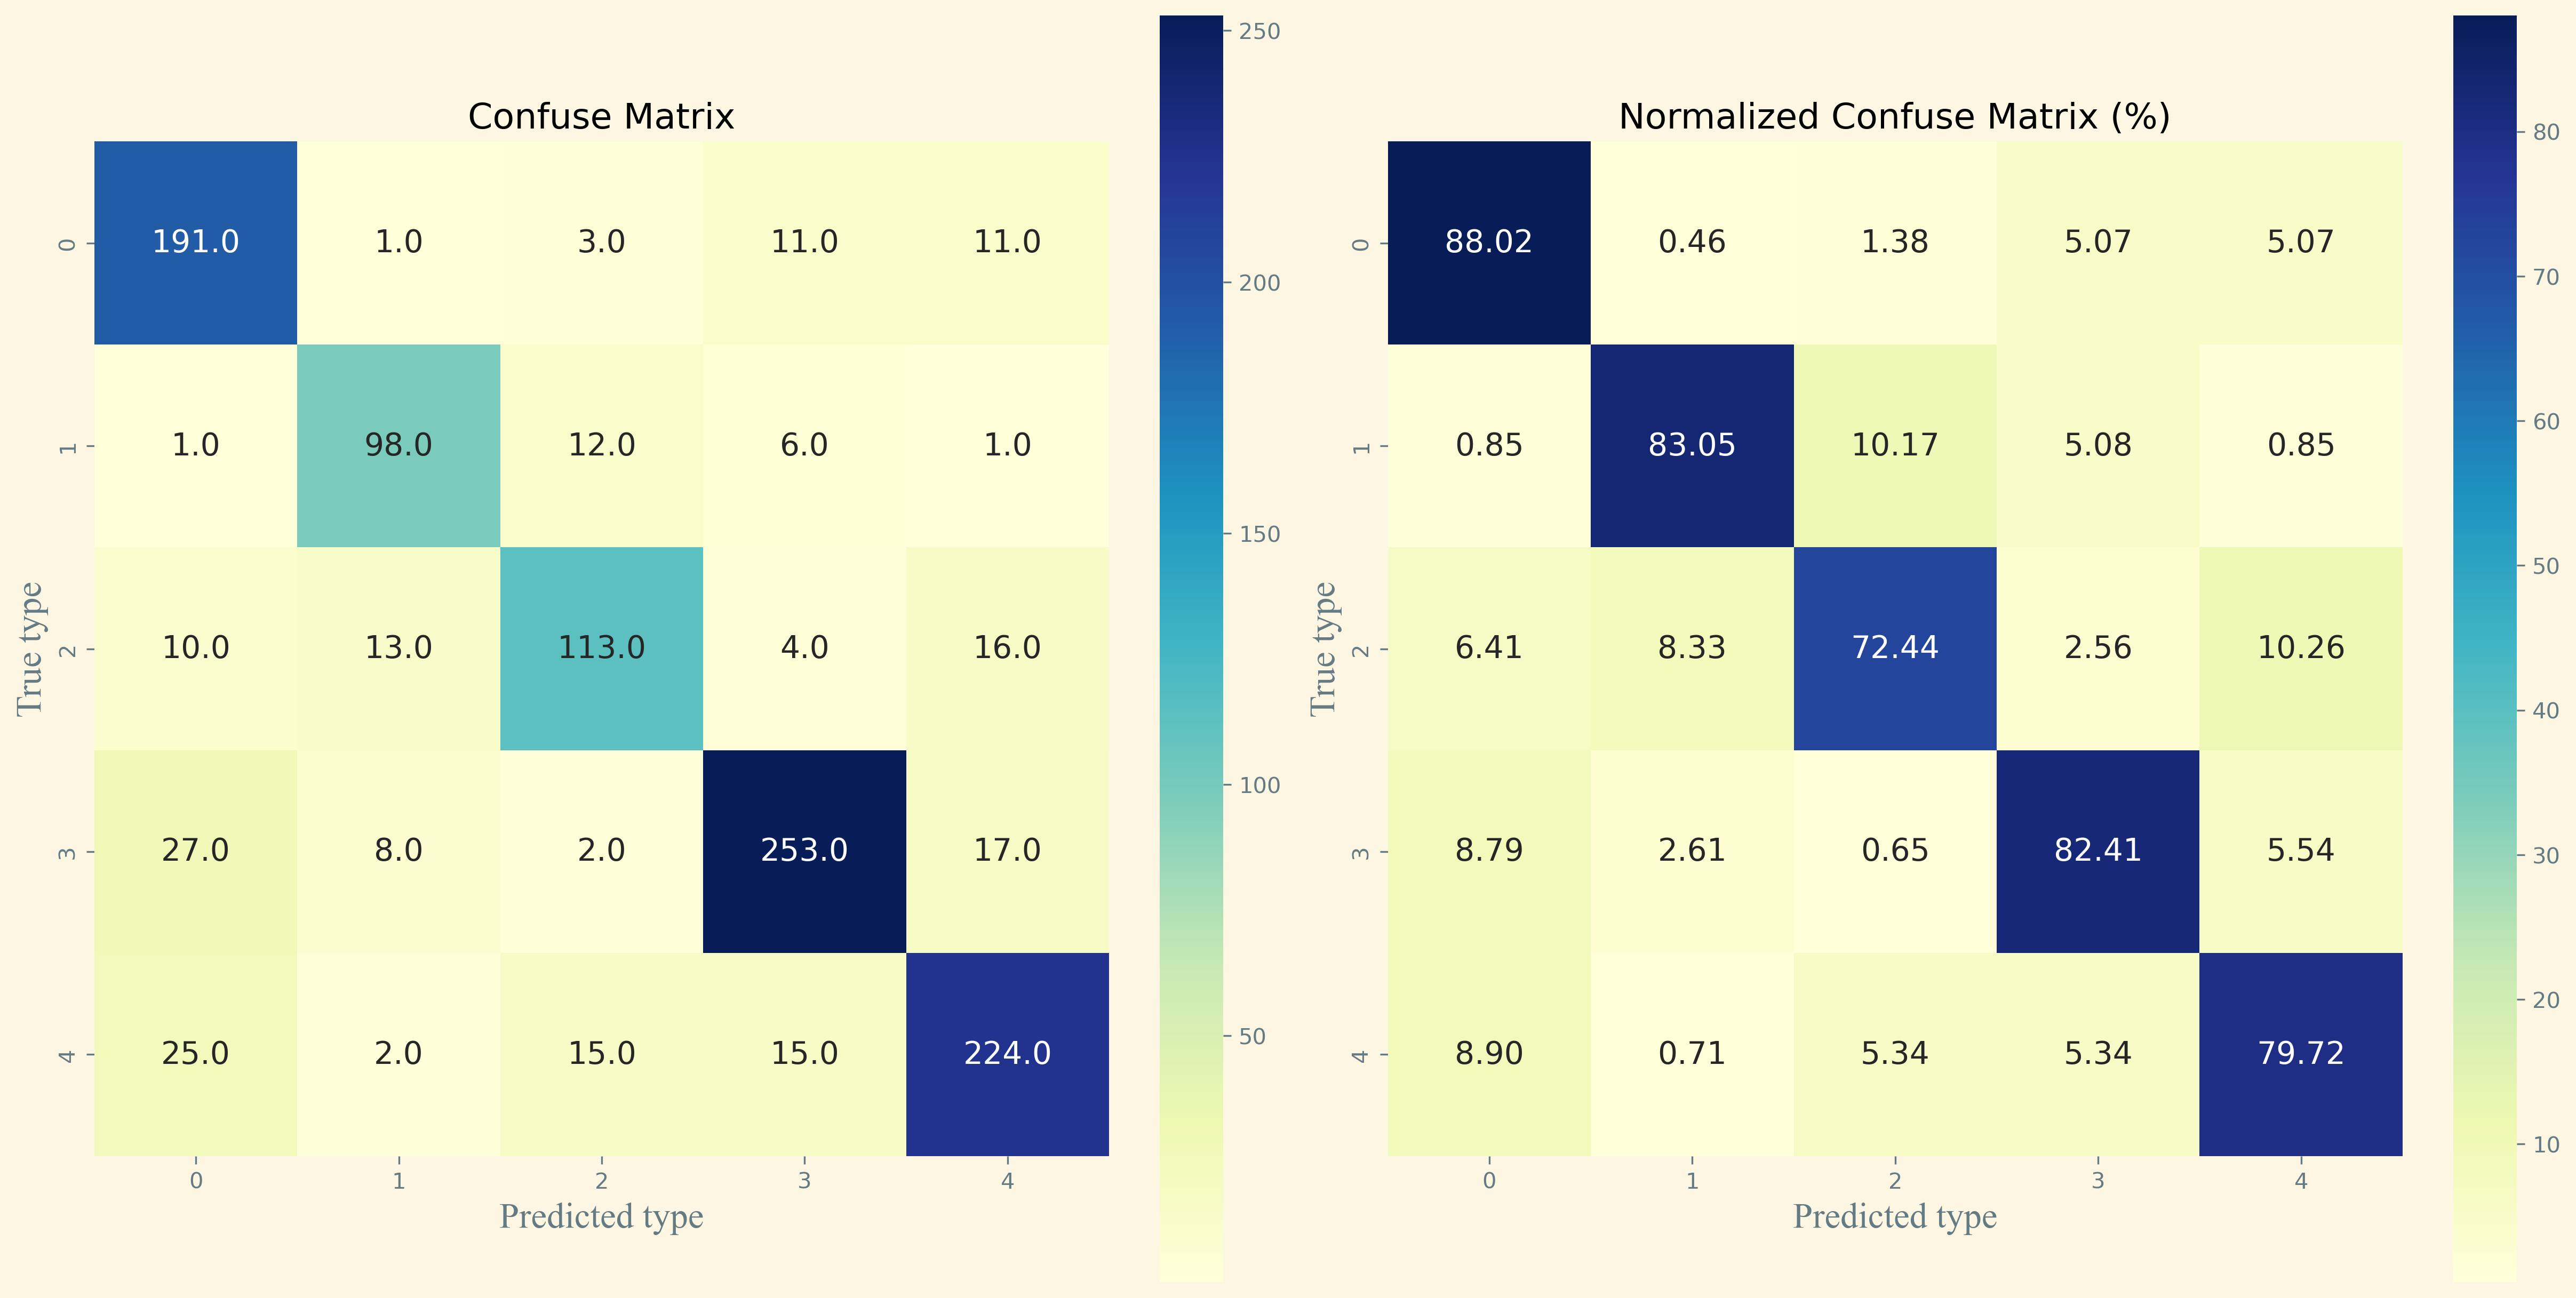

In [6]:
for emg_denoise_method in emg_denoise_methods:
    file_path = os.path.join(os.path.dirname(os.getcwd()) , 'preProcessing', 'SIAT_LLMD_trainData', emg_denoise_method)
    
    for target_subject_order in subjects_list_global1:
        clear()
        target_subject = 'Sub'+target_subject_order
        source_subjects_list = subjects_list_global.copy()
        source_subjects_list.remove(target_subject_order)
        source_path_list = [os.path.join(file_path, ''.join(['Sub', str(k), '_targetTrainData.npz'])) for k in source_subjects_list]
        x_train, y_train, x_valid, y_valid, x_test, y_test = get_source_datasets(source_path_list, data_name='sub_emg_sample', label_name='sub_motion_label_encoded')
        source_train_loader, source_valid_loader, source_test_loader = get_dl_dataloaders(x_train, y_train, x_valid, y_valid, x_test, y_test)
        model = CNNBiGRU()
        model_name = model.get_model_name()
        model.double()
        model.to(device=device)
        save_path = os.path.join(os.path.dirname(os.getcwd()) , 'results', 'Inter_Deep_Learning', emg_denoise_method, 'Source', target_subject)
        settings['save_path'] = save_path
    
        printlog(info='Denoising method: %s, model: %s'% (emg_denoise_method, model_name), time=True, line_break=False)
        print('Target subject: ', target_subject_order, ', Source subjects: ', source_subjects_list)
        print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
        print('x_valid.shape: ', x_valid.shape, ', y_valid.shape: ', y_valid.shape)
        print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
        print('Sample size of train set, valid set and test set are: ', len(source_train_loader.dataset), len(source_valid_loader.dataset), len(source_test_loader.dataset))

        train_test_dl_models_source(settings, model, source_train_loader, source_valid_loader, source_test_loader)

### 2. Target Domain Model Training and Test

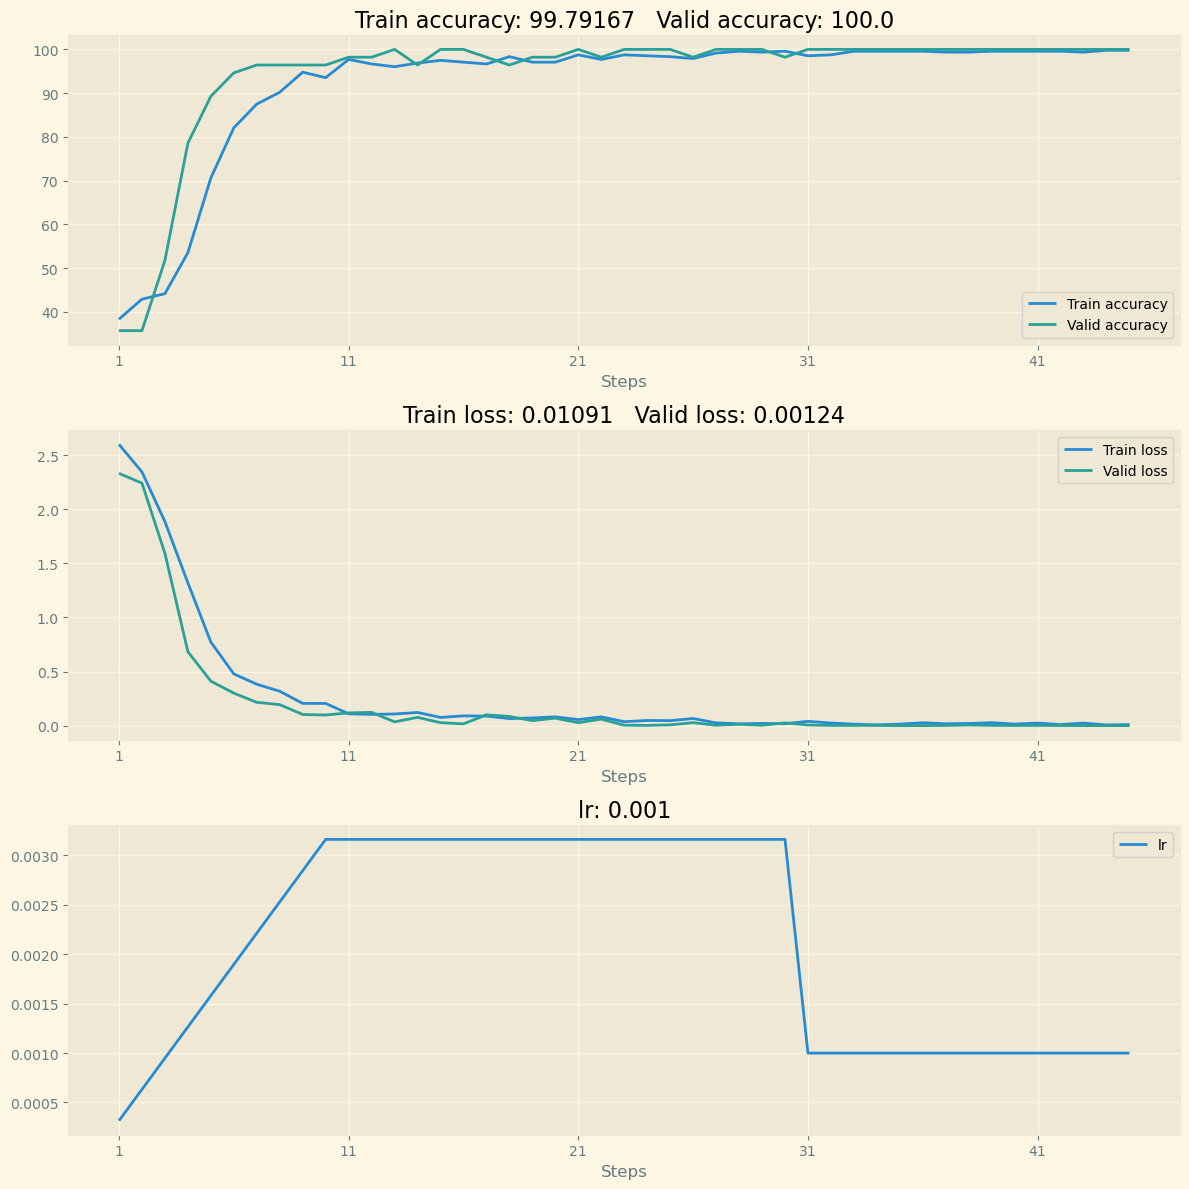

EarlyStopping counter: 10 out of 10
Early stopping, save the model: 
Save the model training process: 
Test results: 
accuracy:  99.27536.
precision:  99.41176.
recall:  98.88889.
f1:  99.13006.
specificity:  99.80952.
npv:  99.83471.
len_train_set:  552.
sampling_time:  17.76.
train_time:  41.56120467185974.
total_time:  59.321204671859746.
Calculate confusion matrix: 
Confusion Matrix: 
[[29  0  0  0  0]
 [ 0 17  0  0  1]
 [ 0  0 20  0  0]
 [ 0  0  0 38  0]
 [ 0  0  0  0 33]]
Normalized Confusion Matrix: 
[[100.           0.           0.           0.           0.        ]
 [  0.          94.44444444   0.           0.           5.55555556]
 [  0.           0.         100.           0.           0.        ]
 [  0.           0.           0.         100.           0.        ]
 [  0.           0.           0.           0.         100.        ]]


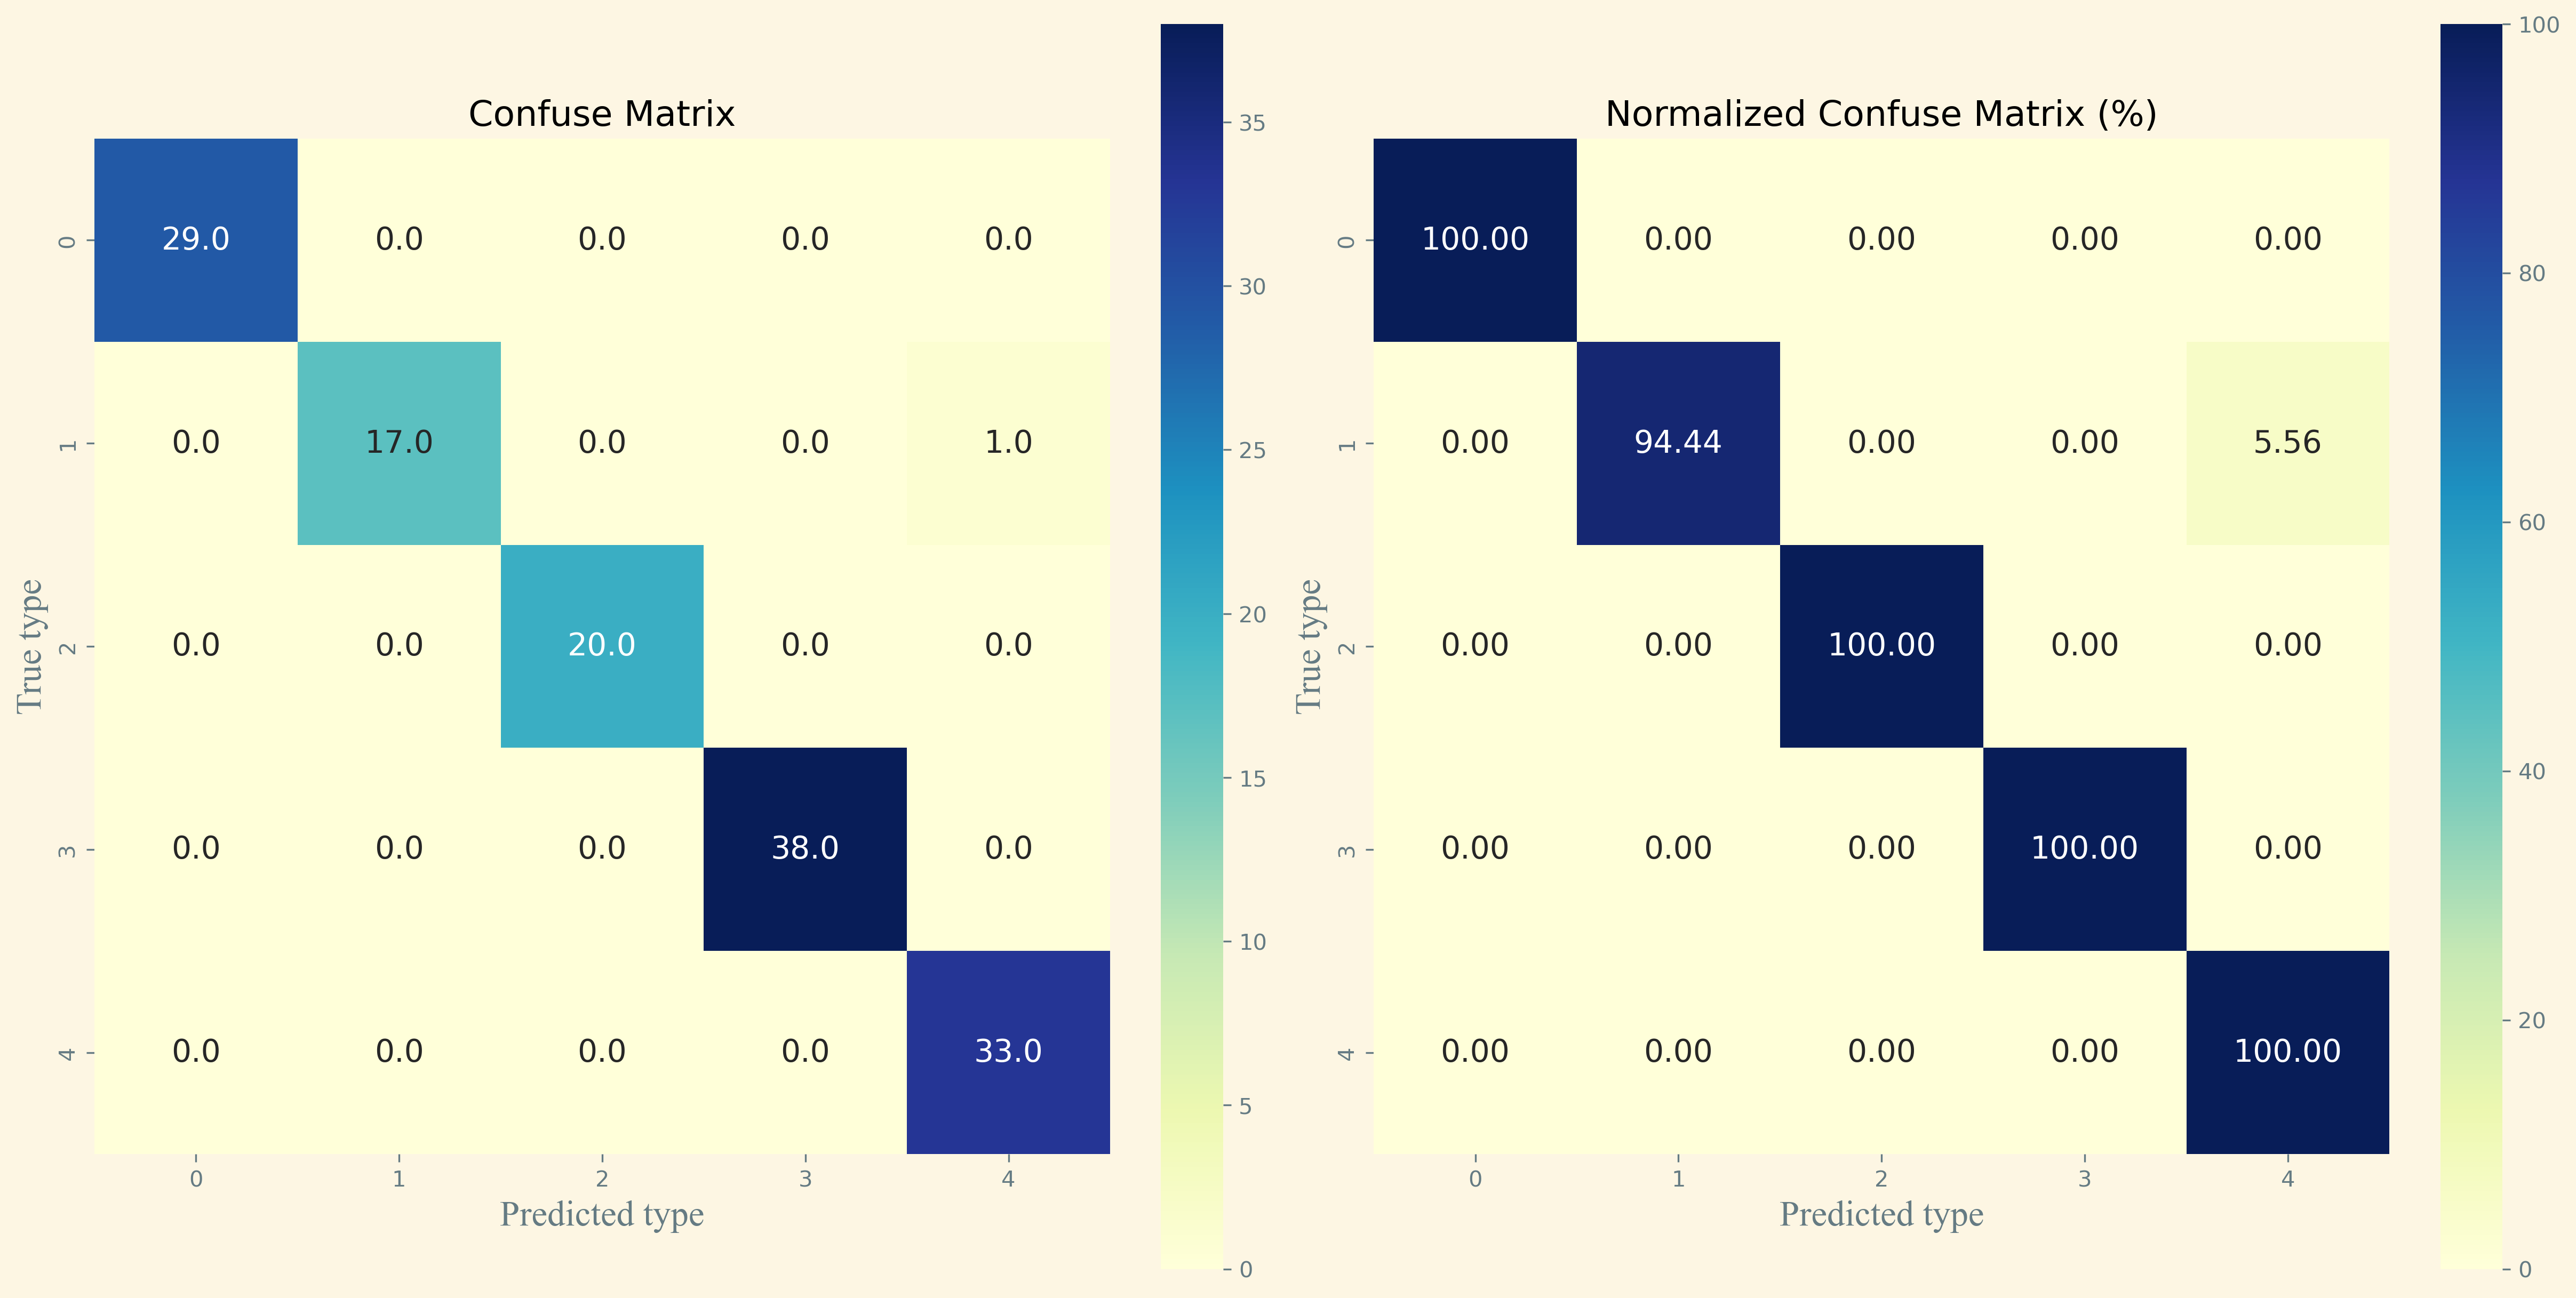

In [3]:
model = CNNBiGRU()
model_name = model.get_model_name()

for tl_type in tl_types:
    settings['tl_type'] = tl_type
    
    for emg_denoise_method in emg_denoise_methods:
        file_path = os.path.join(os.path.dirname(os.getcwd()) , 'preProcessing', 'SIAT_LLMD_trainData', emg_denoise_method)
        
        for target_subject_order in subjects_list_global1:
            target_subject = 'Sub'+target_subject_order
            file_name = get_file_name(file_path, target_subject_order, subjects_list_global)
            save_path = os.path.join(os.path.dirname(os.getcwd()) , 'results', 'Inter_Deep_Learning', emg_denoise_method, 'Target', tl_type, target_subject)
            settings['save_path'] = save_path
            source_model_name = os.path.join(os.path.dirname(os.getcwd()) , 'results', 'Inter_Deep_Learning', emg_denoise_method, 'Source', target_subject, 'source_model.pt')
            all_x_train, all_y_train, all_x_valid, all_y_valid, all_x_test, all_y_test = get_dl_datasets(file_name, data_name='sub_emg_sample', label_name='sub_motion_label_encoded')

            for exp_tim in range(total_exp_time):
                clear()
                x_train, y_train, x_valid, y_valid, x_test, y_test = all_x_train[exp_tim], all_y_train[exp_tim], all_x_valid[exp_tim], all_y_valid[exp_tim], all_x_test[exp_tim], all_y_test[exp_tim]
                train_loader, valid_loader, test_loader = get_dl_dataloaders(x_train, y_train, x_valid, y_valid, x_test, y_test)
                current_exp_time = exp_tim + 1
                settings['current_exp_time'] = current_exp_time
                len_train_set = len(train_loader.dataset)+len(valid_loader.dataset)
                sampling_time = (window+(len_train_set-1)*(window-step)) / tar_fs
                settings['len_train_set'] = len_train_set
                settings['sampling_time'] = sampling_time
                
                printlog(info='Types of Transfer Learning: %s'% tl_type, time=True, line_break=False)
                printlog(info='Denoising method: %s, model: %s'% (emg_denoise_method, model_name), time=True, line_break=False)
                printlog(info='Target subject: %s' % target_subject, time=True, line_break=False)
                printlog(info='Number of trails: %d / %d' % (current_exp_time, total_exp_time), time=True, line_break=False)
                print('dataset_partitioning_method: ', partitioning_method)
                print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
                print('x_valid.shape: ', x_valid.shape, ', y_valid.shape: ', y_valid.shape)
                print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
                print('Sample size of train set, valid set and test set are: ', len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset))
                
                train_test_dl_models_target(settings, source_model_name, train_loader, valid_loader, test_loader)